Author: Bahavathy Kathirgamanathan

Data for use with this tutorial can be found at https://zenodo.org/records/7997851
Please cite the following article when using this data:

B. Kathirgamanathan, B. Caulfield and P. Cunningham, "Towards Globalised Models for Exercise Classification using Inertial Measurement Units," 2023 IEEE 19th International Conference on Body Sensor Networks (BSN), Boston, MA, USA, 2023, pp. 1–4, doi: 10.1109/BSN58485.2023.10331612

In [1]:
from sktime.transformations.panel.rocket import Rocket
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneGroupOut

import pandas as pd
import numpy as np

In [2]:
filename = "Accel_mag_all.csv"
data = pd.read_csv(filename, header = None)

In [3]:
X = data.iloc[:,2:].values

y =  data[1].values

participant_no =  data[0].values

### Leave-One-Subject-Out Classification

In [4]:
logo = LeaveOneGroupOut()

logo.get_n_splits(X, y, participant_no)

19

In [5]:
rocket_pipeline_ridge = make_pipeline(
    Rocket(random_state=0), 
    StandardScaler(), 
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)

In [7]:
Rocket_score_glob = []
for i, (train_index, test_index) in enumerate(logo.split(X, y, participant_no)):
    rocket_pipeline_ridge.fit(X[train_index], y[train_index])

    Rocket_score = rocket_pipeline_ridge.score(X[test_index],y[test_index])
    Rocket_score_glob = np.append(Rocket_score_glob, Rocket_score)

In [8]:
print("Global Model Results")
print(f"mean accuracy: {np.mean(Rocket_score_glob)}")
print(f"standard deviation: {np.std(Rocket_score_glob)}")
print(f"minimum accuracy: {np.min(Rocket_score_glob)}")
print(f"maximum accuracy: {np.max(Rocket_score_glob)}")

Global Model Results
mean accuracy: 0.5919805636306338
standard deviation: 0.10360659996594646
minimum accuracy: 0.4709480122324159
maximum accuracy: 0.8283582089552238


### Personalised Classification

In [23]:
Rocket_score_pers = []
for i, (train_index, test_index) in enumerate(logo.split(X, y, participant_no)):
    
    #print(f"Participant: {participant_no[test_index][0]}")
    label = y[test_index]
    X_S = X[test_index]
    
    # Identify the indices for each class
    class_0_indices = np.where(label == 'NF')[0]
    class_1_indices = np.where(label == 'F')[0]
    
    # Split each class into train and test using indexing
    class_0_split_index = int(0.66 * len(class_0_indices))
    class_1_split_index = int(0.66 * len(class_1_indices))

    X_train = np.concatenate((X_S[class_0_indices[:class_0_split_index]], X_S[class_1_indices[:class_1_split_index]]), axis=0)
    y_train = np.concatenate((label[class_0_indices[:class_0_split_index]], label[class_1_indices[:class_1_split_index]]), axis=0)
    
    X_test = np.concatenate((X_S[class_0_indices[class_0_split_index:]],X_S[class_1_indices[class_1_split_index:]]), axis=0)
    y_test = np.concatenate((label[class_0_indices[class_0_split_index:]], label[class_1_indices[class_1_split_index:]]), axis=0)
    
    rocket_pipeline_ridge.fit(X_train, y_train)

    Rocket_score_pers = np.append(Rocket_score_pers, rocket_pipeline_ridge.score(X_test,y_test))

In [24]:
print("Personalised Model Results")
print(f"mean accuracy: {np.mean(Rocket_score_pers)}")
print(f"standard deviation: {np.std(Rocket_score_pers)}")
print(f"minimum accuracy: {np.min(Rocket_score_pers)}")
print(f"maximum accuracy: {np.max(Rocket_score_pers)}")


Personalised Model Results
mean accuracy: 0.9517626092184379
standard deviation: 0.07750979452994386
minimum accuracy: 0.7037037037037037
maximum accuracy: 1.0


### Plot Results

In [25]:
import matplotlib.pyplot as plt

In [31]:
x_axis = np.arange(len(np.unique(participant_no)))
x_labels = np.unique(participant_no)

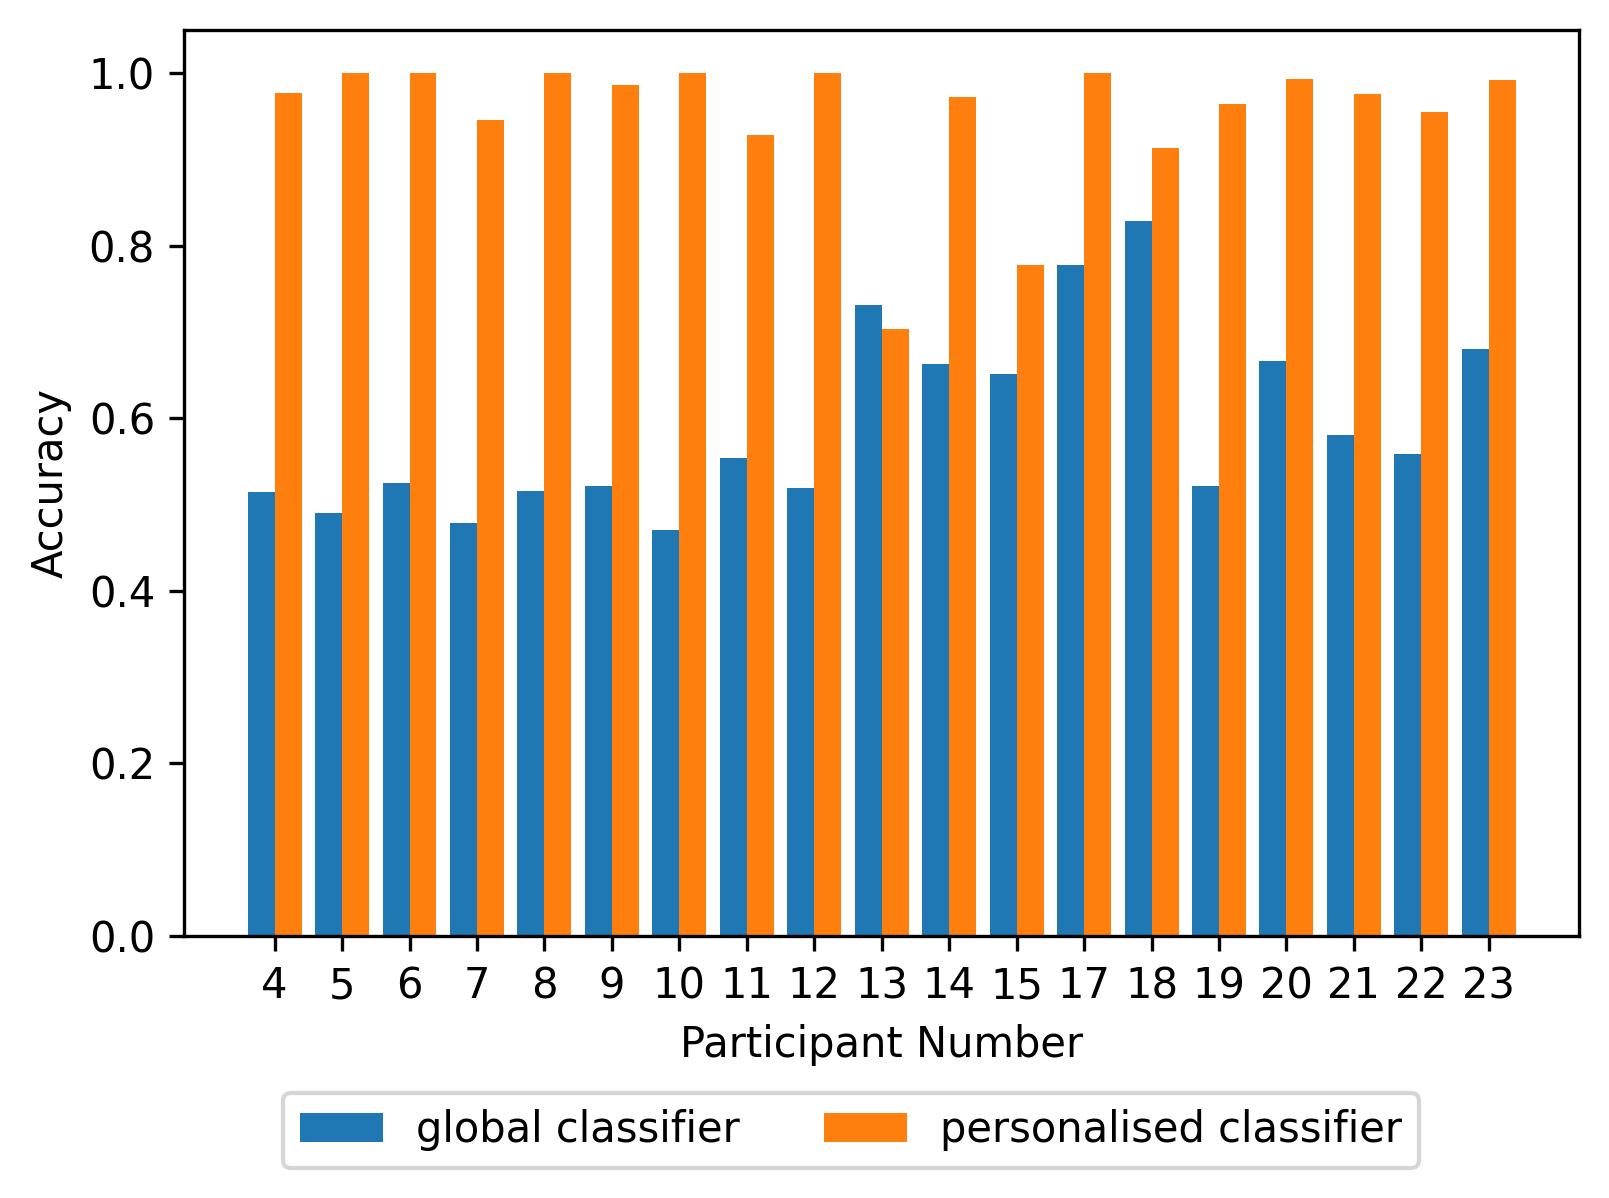

In [54]:
fig = plt.figure(dpi = 300)
plt.bar(x_axis-0.2, Rocket_score_glob, width=0.4, label = "global classifier")
plt.bar(x_axis+0.2, Rocket_score_pers, width=0.4, label = "personalised classifier")

plt.xticks(x_axis, x_labels)
plt.xlabel("Participant Number")
plt.ylabel("Accuracy")

plt.legend(bbox_to_anchor=(0.9, -0.15), ncol=2)

plt.show()

In [55]:
fig.savefig("globalVsPersonalised.png", dpi = 300, bbox_inches = 'tight')